In [27]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, multilabel_confusion_matrix

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
# Path Setup
train_path = "Training"
test_path = "Testing"
img_size = 224
batch_size = 32

# Data Augmentation & Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path, target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='categorical', shuffle=False
)

class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)

Found 4800 images belonging to 4 classes.
Found 1200 images belonging to 4 classes.


In [29]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(img_size, img_size, 3))
base_model.trainable = True  # Fine-tune

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(learning_rate=0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
callbacks = [early_stop, lr_reduce]

history = model.fit(train_generator, validation_data=test_generator, epochs=10, callbacks=callbacks)

# Save Trained Model
model.save("efficientnetb0.h5")

C:\Users\chand\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 637s 4s/step - accuracy: 0.5808 - loss: 0.9965 - val_accuracy: 0.2367 - val_loss: 1.4280 - learning_rate: 5.0000e-05
Epoch 2/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.8816 - loss: 0.3193 - val_accuracy: 0.2450 - val_loss: 1.3630 - learning_rate: 5.0000e-05
Epoch 3/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 552s 4s/step - accuracy: 0.9244 - loss: 0.2152 - val_accuracy: 0.2508 - val_loss: 2.3584 - learning_rate: 5.0000e-05
Epoch 4/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 553s 4s/step - accuracy: 0.9332 - loss: 0.1831 - val_accuracy: 0.2850 - val_loss: 1.4464 - learning_rate: 5.0000e-05
Epoch 5/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 550s 4s/step - accuracy: 0.9494 - loss: 0.1447 - val_accuracy: 0.7875 - val_loss: 0.6396 - learning_rate: 1.0000e-05
Epoch 6/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 559s 4s/step - accuracy: 0.9507 - loss: 0.1356 - val_accuracy: 0.8300 - val_loss: 0.5018 - learning_rate: 1.0000e-05
Epoch 7/10
150/150 ━━━━━━━━━━━━━━━━━━━━ 555s 4s/step - acc

In [31]:
loss, acc = model.evaluate(test_generator, verbose=0)
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)


print(f"EfficientNetB0 Accuracy: {acc:.4f}")

EfficientNetB0 Accuracy: 0.9167


In [32]:
cr = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_true), y_pred_probs, multi_class='ovr')

print(f"Precision: {cr['macro avg']['precision']:.4f}")
print(f"Recall: {cr['macro avg']['recall']:.4f}")
print(f"F1 Score: {cr['macro avg']['f1-score']:.4f}")
print(f"AUC-ROC Score: {roc_auc:.4f}")

Precision: 0.9183
Recall: 0.9167
F1 Score: 0.9153
AUC-ROC Score: 0.9920


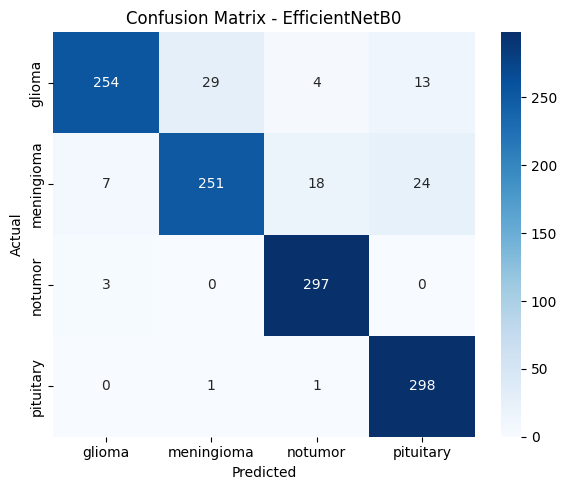

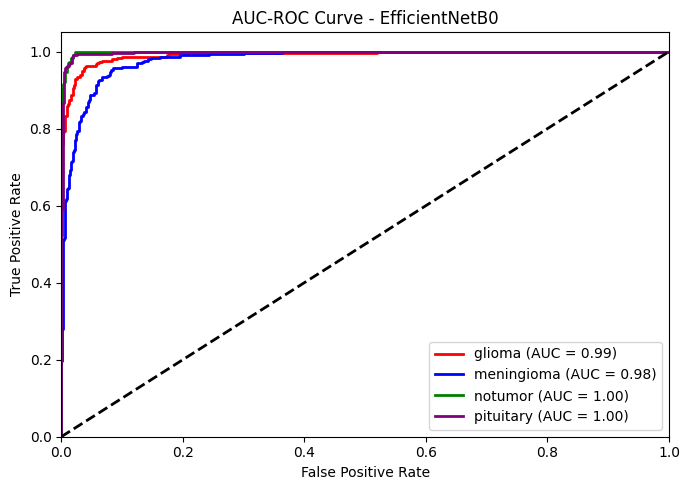

In [33]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - EfficientNetB0")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# AUC-ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
fpr = dict()
tpr = dict()
roc_auc_vals = dict()

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc_vals[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(7, 5))
colors = cycle(['red', 'blue', 'green', 'purple'])
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc_vals[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC-ROC Curve - EfficientNetB0')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

In [34]:
mcm = multilabel_confusion_matrix(y_true, y_pred)
tp = mcm[:, 1, 1].sum()
tn = mcm[:, 0, 0].sum()
fp = mcm[:, 0, 1].sum()
fn = mcm[:, 1, 0].sum()
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0

result = pd.DataFrame([{
    "Model": "EfficientNetB0",
    "Accuracy": acc,
    "Precision": cr['macro avg']['precision'],
    "Recall": cr['macro avg']['recall'],
    "Specificity": specificity,
    "F1-Score": cr['macro avg']['f1-score'],
    "AUC-ROC": roc_auc,
    "TP": tp,
    "TN": tn,
    "FP": fp,
    "FN": fn
}])

csv_path = "all_model_results.csv"
if os.path.exists(csv_path):
    result.to_csv(csv_path, mode='a', header=False, index=False)
else:
    result.to_csv(csv_path, index=False)

print("✅ Results saved to all_model_results.csv")

✅ Results saved to all_model_results.csv
